In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import tikzplotlib as tikz

def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

data_path = os.path.join(os.getcwd(), "data")
figs_path = os.path.join(os.getcwd(), "figs")

In [2]:
types, pixels, index = 3, 2001, 0
int_celltypes = ['Astrocytes', 'Purkinje', 'Granule', 'Bergmann', 'Oligodendrocytes', 'MLI1', 'MLI2']
int_celltypes = int_celltypes[:types]
cell_dict = {celltype : index for index, celltype in enumerate(int_celltypes)}
true_W = np.loadtxt(os.path.join(data_path,
                                 'true_W-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=',')
prior_W = np.loadtxt(os.path.join(data_path,
                                 'prior-curr_W-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=' ')
noprior_W = np.loadtxt(os.path.join(data_path,
                                 'noprior-curr_W-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=' ')
true_S = np.loadtxt(os.path.join(data_path,
                                 'sc_S-'+
                                 str(types)+'.csv'), delimiter=',')
prior_S = np.loadtxt(os.path.join(data_path,
                                 'prior-curr_S-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=' ')
noprior_S = np.loadtxt(os.path.join(data_path,
                                 'noprior-curr_S-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=' ')

In [3]:
def class_row(curr, classes):
    output = []
    for i in classes:
        if type(i) is int:
            output.append(curr[i])
        else:
            output.append(sum(curr[x] for x in i))
    return output
def determine_perm(true, pred, norm=True):
    output = []
    if norm:
        pred = pred.T / pred.sum(axis=1)
    for t in true:
        max_r2 = None
        argmax = None
        for i, p in enumerate(pred):
            r2 = rsquared(t, p)
            if max_r2 is None or r2 > max_r2:
                max_r2 = r2
                argmax = i
        output.append(argmax)
    return output
permutation = determine_perm(true_W, noprior_W)

In [4]:
def plot(true, pred, permutation, types, labels, plot_S = False, violin = True, save_tikz = False, prior = False):
    types = len(classes)
    fig, ax = plt.subplots(1,types,figsize=(types*5,5))

    for i, (label, true_row, curr_row) in enumerate(zip(labels,
                                           class_row(true, classes),
                                           class_row([pred[j] for j in permutation], classes))):
        ax[i].set_title(label + (" gene expression" if plot_S else " weight"))
        if plot_S:
            true_row = np.log(np.maximum(true_row, np.exp(-16)))
            curr_row = np.log(np.maximum(curr_row, np.exp(-16)))
        
        if violin and not plot_S:
            for k in range(10):
                scale = (true_row.max() - true_row.min())
                m = true_row.min()
                k = k/10.0*scale
                cut = (true_row >= m+k) & (true_row <= m+k+0.1*scale)
                if sum(cut) > 0:
                    ax[i].scatter(true_row[cut], curr_row[cut], s=5)
                    ax[i].violinplot(curr_row[cut], positions=[m+k+0.05*scale], 
                                     widths=0.08*scale, showmeans = True)
            ax[i].plot([true_row.min(), true_row.max()], [true_row.min(), true_row.max()],
                       label=r'$r^2=%.5g$' % rsquared(curr_row,true_row))
        else:
            ax[i].scatter(true_row, curr_row, s=5)
            ax[i].plot([true_row.min(), true_row.max()], [true_row.min(), true_row.max()], label=r'$y=x$')
        
        if i == 0:
            ax[i].set_ylabel('Predicted value')
        elif not plot_S:
            ax[i].tick_params(
                axis='y',
                which='both',
                bottom=False,
                left=False, 
                labelleft=False)
        ax[i].set_xlabel('True value')
        ax[i].legend()
        print(sum((true_row-curr_row)**2))
    plt.tight_layout()
    if save_tikz:
        tikz.save(os.path.join(figs_path,'%s-%s-%s-%s.tex' % ('S' if plot_S else 'W',
                                                           'violin' if violin else 'scatter',
                                                           'prior' if prior else 'noprior',
                                                           types
                                                          )),encoding='utf-8')
    plt.show()

53.252214588399646
44.009385647404436
108.4498565245374


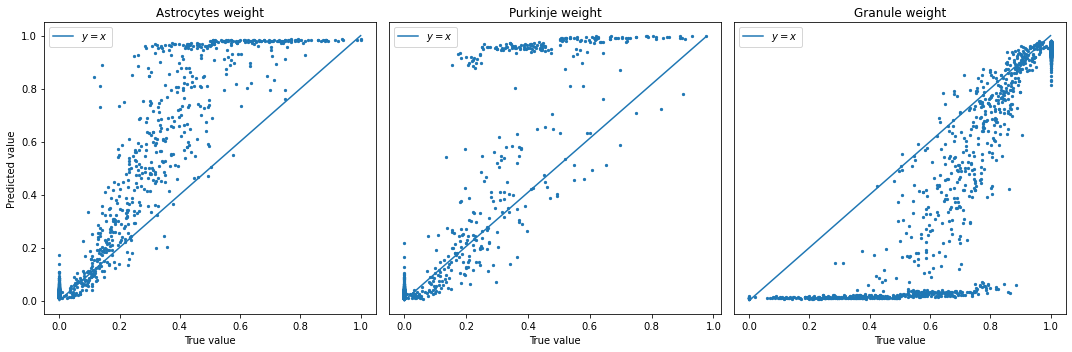

53.252214588399646
44.009385647404436
108.4498565245374


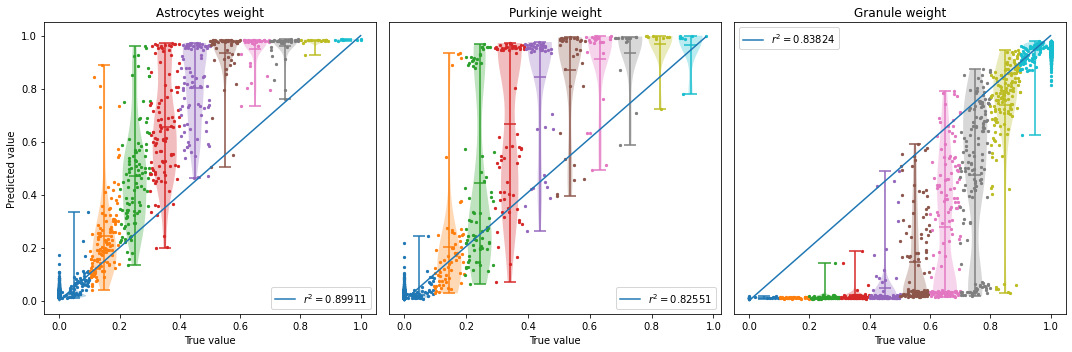

68.47958638675998
46.62614870962012
138.57626927196486


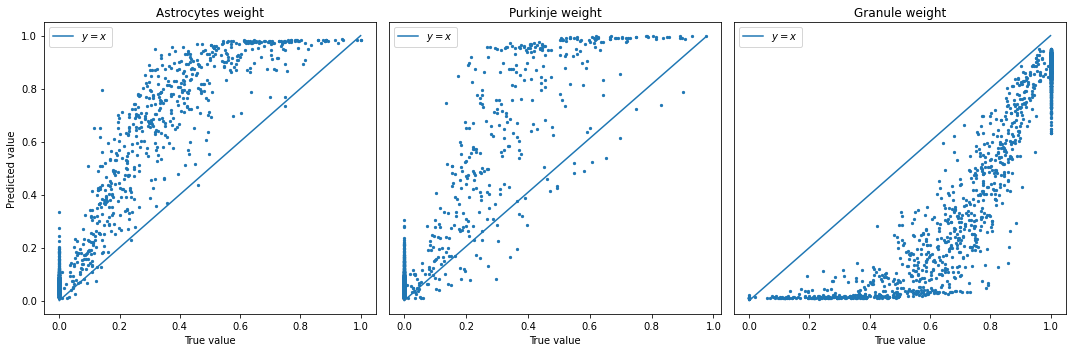

68.47958638675998
46.62614870962012
138.57626927196486


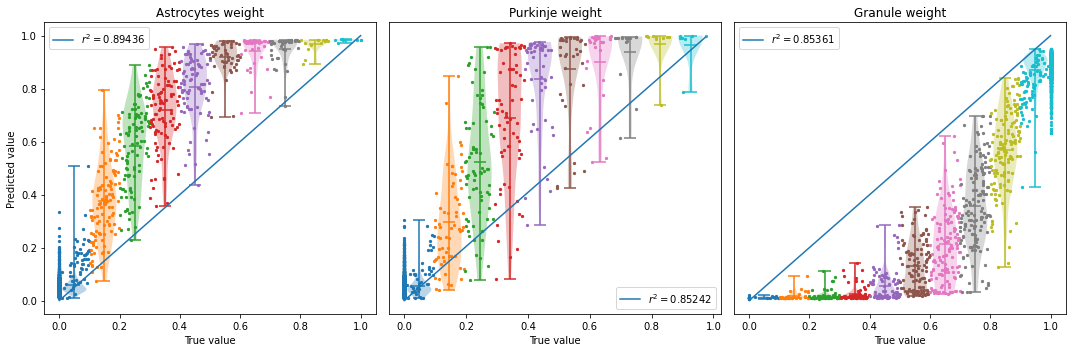

In [5]:
permutation = determine_perm(true_W, prior_W)
labels = int_celltypes
classes = [i for i in range(types)]

pred = (prior_W.T / prior_W.sum(axis=1))
plot(true_W, pred, permutation, classes, labels, violin = False, prior = True, save_tikz = True)
plot(true_W, pred, permutation, classes, labels, prior = True, save_tikz = True)

pred = (noprior_W.T / noprior_W.sum(axis=1))
plot(true_W, pred, permutation, classes, labels, violin = False, save_tikz = True)
plot(true_W, pred, permutation, classes, labels, save_tikz = True)

30800.392662769707
37392.28122830186
31453.886240666816


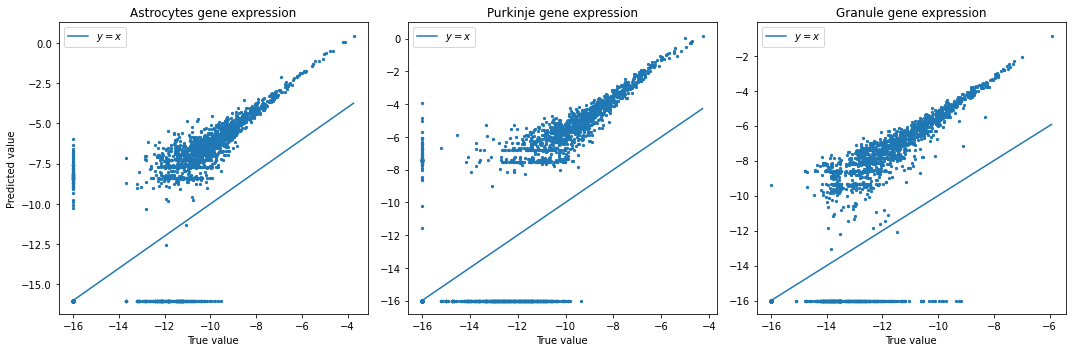

29679.881705836367
34843.35135843429
43892.998033575335


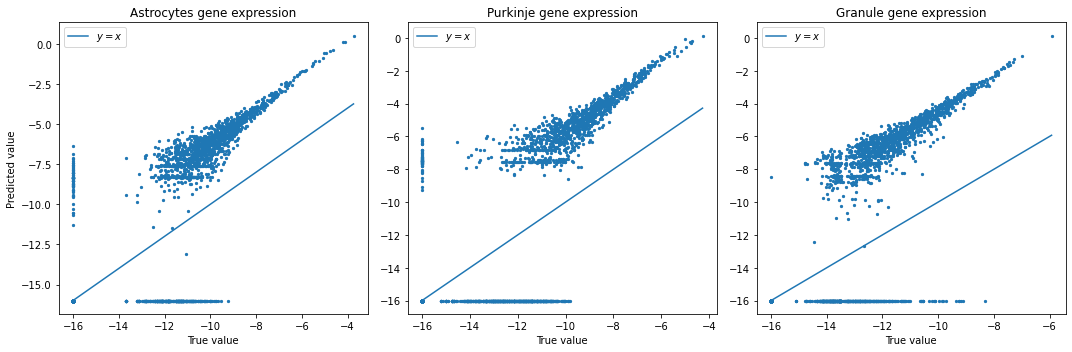

In [6]:
permutation = determine_perm(true_W, prior_W)
labels = int_celltypes
classes = range(3)
pred = prior_S.T
plot(true_S, pred, permutation, classes, labels, plot_S=True, prior = True, save_tikz = True)
pred = noprior_S.T
plot(true_S, pred, permutation, classes, labels, plot_S=True, save_tikz = True)

In [7]:
types, pixels, index = 5, 5000, 0
int_celltypes = ['Astrocytes', 'Purkinje', 'Granule', 'Bergmann', 'Oligodendrocytes', 'MLI1', 'MLI2']
int_celltypes = int_celltypes[:types]
cell_dict = {celltype : index for index, celltype in enumerate(int_celltypes)}
true_W = np.loadtxt(os.path.join(data_path,
                                 'true_W-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=',')
prior_W = np.loadtxt(os.path.join(data_path,
                                 'prior-curr_W-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=' ')
noprior_W = np.loadtxt(os.path.join(data_path,
                                 'noprior-curr_W-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=' ')
true_S = np.loadtxt(os.path.join(data_path,
                                 'sc_S-'+
                                 str(types)+'.csv'), delimiter=',')
prior_S = np.loadtxt(os.path.join(data_path,
                                 'prior-curr_S-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=' ')
noprior_S = np.loadtxt(os.path.join(data_path,
                                 'noprior-curr_S-'+
                                 str(types)+'-'
                                 +str(pixels)+'-'
                                 +str(index)+'.csv'), delimiter=' ')

171.50257027217845
19.012161659749314
166.27426297259316
289.39130683365113
26.20425996277958


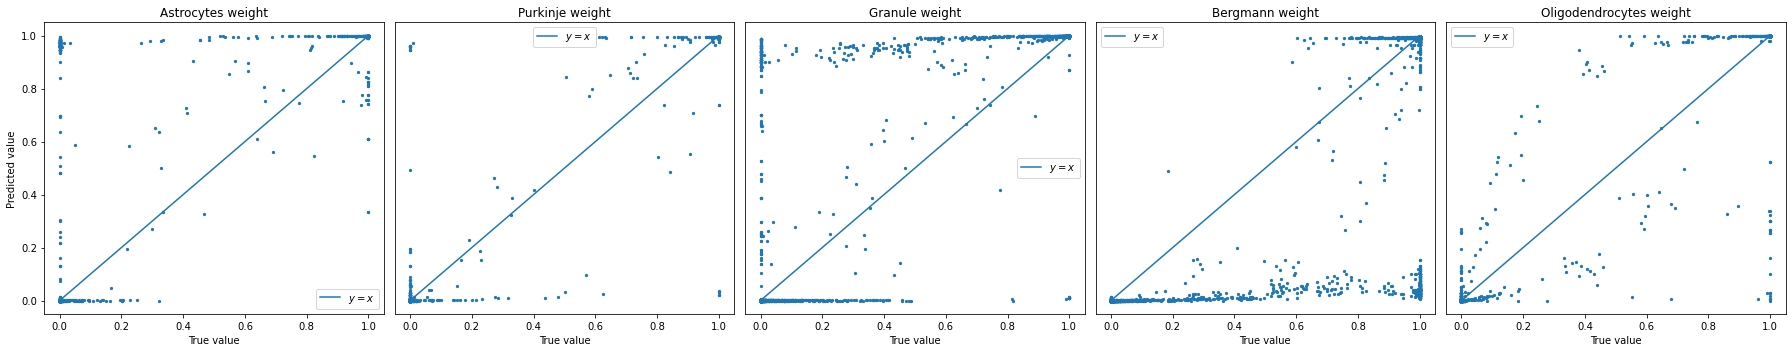

171.50257027217845
19.012161659749314
166.27426297259316
289.39130683365113
26.20425996277958


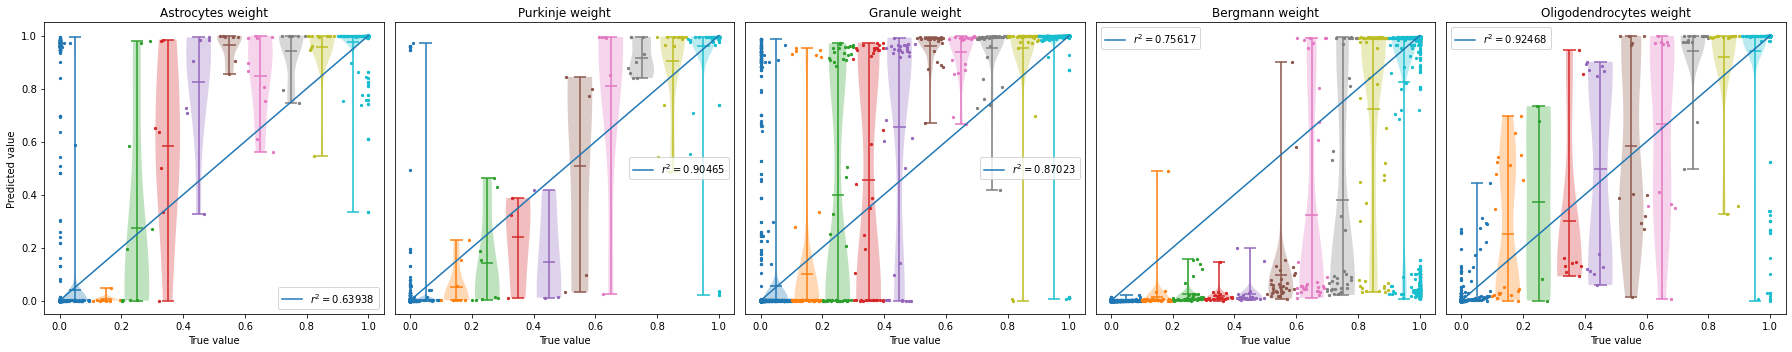

144.74397464145125
51.50978833610001
192.94060056462465
126.89178003863523
46.00991056703924


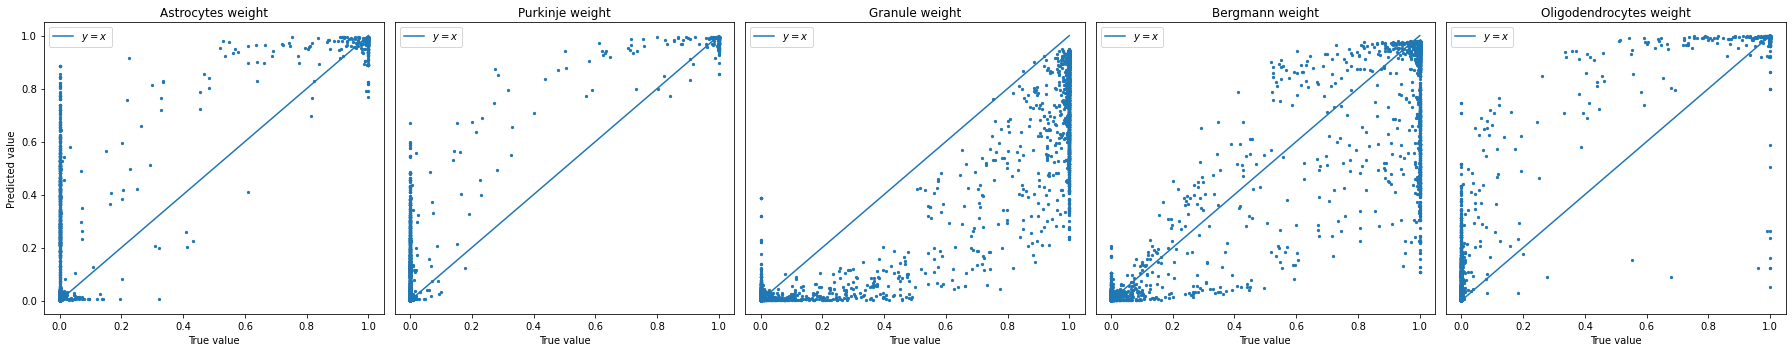

144.74397464145125
51.50978833610001
192.94060056462465
126.89178003863523
46.00991056703924


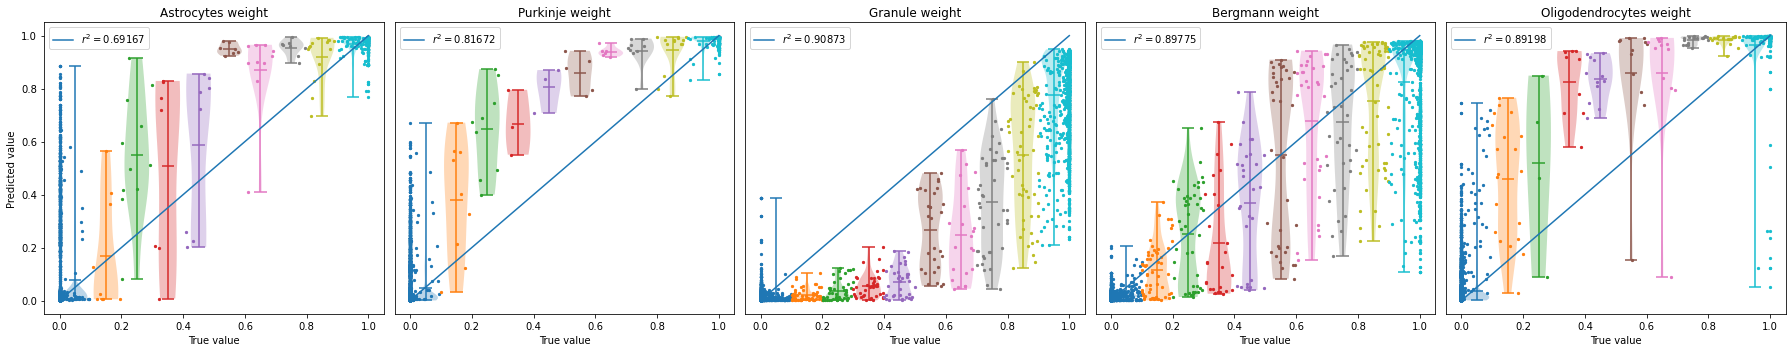

In [46]:
permutation = determine_perm(true_W, prior_W)
labels = int_celltypes
classes = [i for i in range(types)]

pred = (prior_W.T / prior_W.sum(axis=1))
plot(true_W, pred, permutation, classes, labels, violin = False, prior = True, save_tikz = True)
plot(true_W, pred, permutation, classes, labels, prior = True, save_tikz = True)

pred = (noprior_W.T / noprior_W.sum(axis=1))
plot(true_W, pred, permutation, classes, labels, violin = False, save_tikz = True)
plot(true_W, pred, permutation, classes, labels, save_tikz = True)